**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](./4-clustering-with-k-means.ipynb).**

---


# Introduction #

In this exercise you'll explore our first unsupervised learning technique for creating features, k-means clustering.

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex4 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("../input/fe-course-data/ames.csv")

The k-means algorithm is sensitive to scale. This means we need to be thoughtful about how and whether we rescale our features since we might get very different results depending on our choices. As a rule of thumb, if the features are already directly comparable (like a test result at different times), then you would *not* want to rescale. On the other hand, features that aren't on comparable scales (like height and weight) will usually benefit from rescaling. Sometimes, the choice won't be clear though. In that case, you should try to use common sense, remembering that features with larger values will be weighted more heavily.

# 1) Scaling Features

Consider the following sets of features. For each, decide whether:
- they definitely should be rescaled,
- they definitely should *not* be rescaled, or
- either might be reasonable

Features:
1. `Latitude` and `Longitude` of cities in California
2. `Lot Area` and `Living Area` of houses in Ames, Iowa
3. `Number of Doors` and `Horsepower` of a 1989 model car

Once you've thought about your answers, run the cell below for discussion.

In [2]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


1. No, since rescaling would distort the natural distances described by Latitude and Longitude.
2. Either choice could be reasonable, but because the living area of a home tends to be more valuable per square foot, it would make sense to rescale these features so that lot area isn't weighted in the clustering out of proportion to its effect on `SalePrice`, if that is what you were trying to predict.
3. Yes, since these don't have comparable units. Without rescaling, the number of doors in a car (usually 2 or 4) would have negligible weight compared to its horsepower (usually in the hundreds).

What you should take away from this is that the decision of whether and how to rescale features is rarely automatic -- it will usually depend on some domain knowledge about your data and what you're trying to predict. Comparing different rescaling schemes through cross-validation can also be helpful. (You might like to check out the `preprocessing` module in scikit-learn for some of the rescaling methods it offers.)


-------------------------------------------------------------------------------

# 2) Create a Feature of Cluster Labels

Creating a k-means clustering with the following parameters:
- features: `LotArea`, `TotalBsmtSF`, `FirstFlrSF`, `SecondFlrSF`,`GrLivArea`
- number of clusters: 10
- iterations: 10

(This may take a moment to complete.)

In [3]:
X = df.copy()
y = X.pop("SalePrice")


# YOUR CODE HERE: Define a list of the features to be used for the clustering
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF','GrLivArea']


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


# YOUR CODE HERE: Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters = 10, n_init=10, random_state=0)
kmeans.fit(X_scaled)
X["Cluster"] = kmeans.predict(X_scaled)


# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [4]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

You can run this cell to see the result of the clustering, if you like.

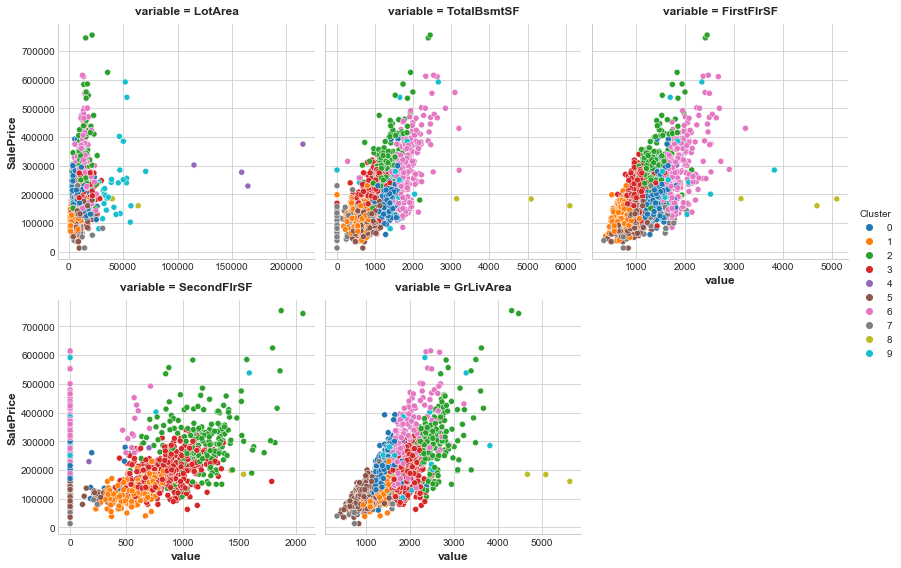

In [5]:
Xy = X.copy()
Xy["Cluster"] = Xy['Cluster'].astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);


And as before, `score_dataset` will score your XGBoost model with this new feature added to training data.

In [6]:
score_dataset(X_scaled, y)

0.23018219494064357

In [7]:
score_dataset(X, y)

-------------------------------------------------------------------------------

The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

# 3) Cluster-Distance Features

Now add the cluster-distance features to your dataset. You can get these distance features by using the `fit_transform` method of `kmeans` instead of `fit_predict`.

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
kmeans.fit(X_scaled)
X_cd = kmeans.transform(X_scaled)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)


# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Run this cell to score these new features, if you like.

In [ ]:
score_dataset(X_cd, y)

0.2402930584143469

# Keep Going #

[**Apply principal components analysis**](./5-principal-component-analysis.ipynb) to create features from variation in your data.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*